In [1]:
pip install pandas

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install scikit-learn

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import json
import re
import nltk
nltk.download('stopwords') 
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/isabelsieh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# import data
single_matrix = pd.read_json('../nlp/ranada_all.json')

In [5]:
# clean data

# remove punctuation marks, symbols, stop words and digits
single_matrix['new_text'] = [re.findall(r'\w+', i.lower()) for i in single_matrix['text'].fillna('NONE')]

In [6]:
# remove stopwords
stopwords = stopwords.words('english')
stopwords += open("../nlp/stopwords-tl.txt").read().splitlines()

new_texts = []
for text in single_matrix['new_text']:
    new_text = []
    for word in text:
        if word not in stopwords and not word.isdigit():
            new_text.append(word)
    
    new_texts.append(new_text) 
    
single_matrix['new_text'] = new_texts

In [7]:
# lemmatise words in the sentences
nltk.download('wordnet')
nltk.download('words')
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
new_texts = []
for text in single_matrix['new_text']:
    new_text = []
    for word in text:
        new_text.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
    new_texts.append(new_text) 
    
single_matrix['new_text'] = new_texts
single_matrix['new_text'] = [' '.join(i) for i in single_matrix['new_text']]

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/isabelsieh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/isabelsieh/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [8]:
single_matrix

,text,user,new_text
0,,james.ranada.9,
1,"AN OPEN LETTER TO Dear Ma’am Pia, I am writing...",malcolm.conlan.full,open letter dear pia write concern unusual int...
2,"IN OTHER WORDS, HINDI KAYO MEDIA So eto nga an...",reyna.elena.73,word kayo media eto nga chika nag renew nang a...
3,Kaw naman,Mochablogger,kaw naman
4,Ms. Pia Ranada para sa kaalaman mo po dahil hi...,Mochablogger,ms pia ranada kaalaman mo po mo ugaling mag re...
...,...,...,...
36815,"PIA RANADA NG RAPPLER, LISTEN...at doon na rin...",erwintulforeal,pia ranada rappler listen rin nag aangas amgas...
36816,LIVE: Catching up with Isko Moreno at Rappler’...,rapplerdotcom,live catch isko moreno rappler hq pia ranada c...
36817,RAPPLER PIA RANADA VS. USEC. BADOY- CREDIBILIT...,100071594142615,rappler pia ranada vs usec badoy credibility c...
36818,"PIA RANADA, NA BURN!!! BURN TO HELL!!!\nSPO4 P...",DugongMaharlikaOfficialPage,pia ranada burn burn hell spo4 pia ranada nasu...


In [9]:
# vectorize text by tfid
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0.0)
tfidf_matrices = []
data_sets = []
source_data = single_matrix
data_sets.append(source_data['new_text'])
tfidf_matrices.append(tf.fit_transform(source_data['new_text']))

In [10]:
# calculate pairwise cosine similarities
from sklearn.metrics.pairwise import linear_kernel
matrix_with_cos_sim = []
for m in tfidf_matrices:
    matrix_with_cos_sim.append(linear_kernel(m, m))

In [11]:
# group similar sentences using network graphs
import numpy as np
from tqdm import trange
top_n_sentences = []
for cs, t in zip(matrix_with_cos_sim, data_sets):
    no_dups = np.array(t)
    i = 0
    top_frame = []
    for c, z in zip(cs, trange(len(cs))):
        # Create vector of titles
        start_name = pd.Series([no_dups[i]]*15) 
        # Index of top 15 similar titles
        ix_top_n = np.argsort(-c)[0:15]
        cos_sim = pd.Series(c[ix_top_n])
        names = pd.Series(no_dups[ix_top_n])
        i +=1
        top_frame.append(pd.DataFrame([start_name, names, cos_sim]).transpose())
    
    top_frame = pd.concat(top_frame)
    top_frame.columns = ['text1', 'text2', 'cos_sim']
    # Remove the similarities for the same sentences
    top_frame['is_same'] = [bool(i==j) for i, j in zip(top_frame['text1'], top_frame['text2'])]
    top_frame = top_frame[top_frame['is_same'] != True]
        
    top_n_sentences.append(top_frame)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 36819/36820 [00:51<00:00, 716.90it/s]


In [12]:
top_n_sentences[0]

,text1,text2,cos_sim,is_same
1,,bobo kaba mo alam bias simple lang bias kayo r...,0.0,False
2,,rappler nakakasira lipunan,0.0,False
3,,karapatan pangulo tumanggi ayaw nya,0.0,False
4,,pia maritis,0.0,False
5,,idol raffy supalpal c bias,0.0,False
...,...,...,...,...
10,nakakagulat sec tugade harap harapang pinahiya...,pia ranada,0.119331,False
11,nakakagulat sec tugade harap harapang pinahiya...,pia ranada,0.119331,False
12,nakakagulat sec tugade harap harapang pinahiya...,pia ranada,0.119331,False
13,nakakagulat sec tugade harap harapang pinahiya...,pia ranada,0.119331,False


In [13]:
# We start by defining the structure of the graph
top_frame = top_n_sentences[0] 
edges = list(zip(top_frame['text1'], top_frame['text2']))
weighted_edges = list(zip(top_frame['text1'], top_frame['text2'], top_frame['cos_sim']))
nodes = list(set(top_frame['text1']).union(set(top_frame['text2'])))

In [14]:
pip install networkx

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Note: you may need to restart the kernel to use updated packages.


In [15]:
# make network
import networkx as nx
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
G.add_weighted_edges_from(weighted_edges)

In [16]:
!pip install python-louvain

In [17]:
import community
partition = community.best_partition(G)
modularity = community.modularity(partition, G)

In [18]:
# Takes some time for larger graphs
import matplotlib.pyplot as plt

In [24]:
G

In [25]:
pos = nx.spring_layout(G, dim=2)

In [36]:
pos2 = nx.kamada_kawai_layout(G)

KeyboardInterrupt: 

In [26]:
community_id = [partition[node] for node in G.nodes()]

In [27]:
fig = plt.figure(figsize=(10,10))

<Figure size 1000x1000 with 0 Axes>

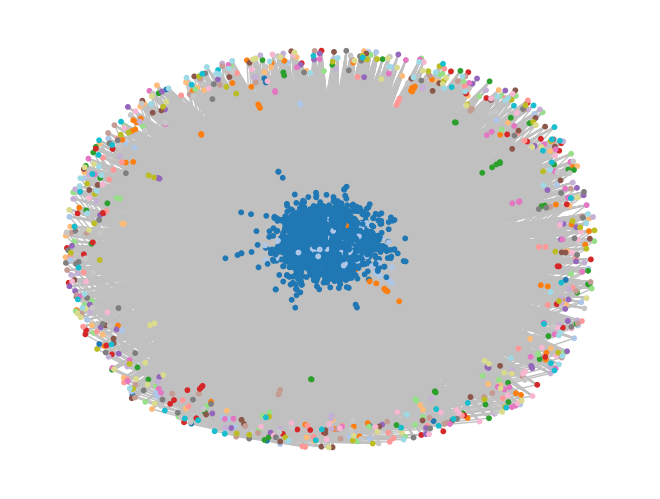

In [37]:
nx.draw(G, pos, edge_color = ['silver']*len(G.edges()), cmap=plt.cm.tab20, node_color=community_id, node_size=10)

In [38]:
text, cluster = [], []
for i in partition.items():
    text.append(i[0])
    cluster.append(i[1])
    
frame_clust = pd.DataFrame([pd.Series(text), pd.Series(cluster)]).transpose()
frame_clust.columns = ['Text', 'Cluster']

In [39]:
frame_clust

,Text,Cluster
0,,0
1,bastos nang bayhana murag kinsa xa lang namn v...,1
2,happen human right lawyer become monster suppr...,2
3,pwede manghingi,3
4,hahahhahaha,4
...,...,...
33878,nagpapapansin lang pia yan maitutulong gov yan...,34
33879,lorelei devine,47
33880,pia ranada rappler nakatikim kay harry roque k...,33
33881,korek sir ban 4ever,9
